# Model Testing - Ryanair Customer Query Classification
## **Objective: Validate trained models on real data before production deployment
## **Pipeline Features:**
### - Automatic best model loading and seup
### - Real-world data prediction testing
### - Confidence score analysis and visualization  
### - Production readiness assessment
### - Deployment recommendations with monitoring insights

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import pickle
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("MODEL DEPLOYMENT TESTING")
print("=" * 50)

MODEL DEPLOYMENT TESTING


## 1. LOAD MODEL & DATA

In [9]:
def load_components():
    """Load best model, vectorizer, and label encoder."""
    try:
        # Load best model info
        with open('../models/evaluation_summary.json', 'r') as f:
            eval_summary = json.load(f)
        
        best_model = eval_summary['best_model']
        expected_f1 = eval_summary['best_f1_score']
        
        print(f" Best Model: {best_model}")
        print(f" Expected F1: {expected_f1:.4f}")
        
        # Load model components
        model = joblib.load(f'../models/optimized_{best_model.lower()}_model.pkl')
        vectorizer = joblib.load(f'../models/optimized_{best_model.lower()}_vectorizer.pkl')
        
        with open('../data/processed/label_encoder.pkl', 'rb') as f:
            label_encoder = pickle.load(f)
        
        print(f" Model loaded: {len(label_encoder.classes_)} classes")
        return model, vectorizer, label_encoder, best_model
        
    except Exception as e:
        print(f" Error: {e}")
        return None, None, None, None

def load_test_data():
    """Load test data or create sample."""
    try:
        test_data = pd.read_csv('../data/processed/test_processed.csv')
        print(f" Real data loaded: {len(test_data):,} samples")
    except:
        # Sample airline queries for demo
        queries = [
            "apply travel voucher book", "current travel restriction", 
            "earn frequent flyer mile", "change flight date fee",
            "baggage allowance international", "cancel booking refund",
            "seat selection premium", "check-in online problem",
            "lost baggage claim", "upgrade business class"
        ] * 100  # Replicate for demo
        
        test_data = pd.DataFrame({'query_lemmatized': queries})
        print(f"Demo data created: {len(test_data)} samples")
    
    return test_data

## 2. PREDICT WITH CONFIDENCE

In [15]:
def load_real_test_data():
    """
    Load real-world test data for production validation.
    
    Returns:
        pd.DataFrame: Test dataset ready for prediction
    """
    print("📄 SECTION 2: REAL TEST DATA LOADING")
    print("-" * 50)
    
    try:
        # Attempt to load processed test data
        print("Searching for test data...")
        test_data = pd.read_csv('../data/processed/test_processed.csv')
        
        print(f"Real Test Data Loaded Successfully!")
        print(f"   Dataset Size: {len(test_data):,} customer queries")
        print(f"   Data Columns: {list(test_data.columns)}")
        
        # Data quality check
        missing_queries = test_data['query_lemmatized'].isnull().sum()
        if missing_queries > 0:
            print(f"    Missing Queries: {missing_queries} ({missing_queries/len(test_data)*100:.1f}%)")
        else:
            print(f"    Data Quality: Complete dataset, no missing values")
            
        print()
        return test_data
        
    except FileNotFoundError:
        print(" Real test data not found. Creating demonstration dataset...")
        
        # Create realistic airline customer service queries for demo
        demo_queries = [
            "apply travel voucher for next booking",
            "current travel restrictions for international flights", 
            "earn frequent flyer miles on this booking",
            "change flight date without extra fees",
            "baggage allowance for international travel",
            "cancel booking and get full refund",
            "seat selection options for premium economy",
            "check-in online not working properly",
            "lost baggage claim and compensation",
            "upgrade to business class availability",
            "travel insurance coverage details needed",
            "group booking discount for 15 passengers",
            "pet travel requirements and restrictions", 
            "duty free shopping pre-order service",
            "wheelchair assistance booking request",
            "unaccompanied minor travel policies",
            "covid-19 testing requirements update",
            "loyalty program benefits and tier status",
            "payment failed during booking process",
            "special meal request for dietary needs"
        ]
        
        test_data = pd.DataFrame({
            'query_lemmatized': demo_queries * 50  # Replicate for demo
        })
        
        print(f"Demo Dataset Created!")
        print(f"   Sample Size: {len(test_data)} queries")
        print(f"   Purpose: Production testing demonstration")
        print()
        
        return test_data

def predict_with_confidence(model, vectorizer, label_encoder, queries):
    """
    Make predictions with confidence scores and top alternatives.
    
    Parameters:
    - model: Trained ML model
    - vectorizer: Fitted TF-IDF vectorizer
    - label_encoder: Label encoder for class names
    - queries: List or Series of query texts
    
    Returns:
    - List of prediction dictionaries with confidence scores
    """
    print(f"🔮 Making predictions on {len(queries):,} queries...")
    
    # Clean and prepare queries
    queries_clean = []
    for query in queries:
        if pd.isna(query) or query is None:
            queries_clean.append("")
        else:
            queries_clean.append(str(query))
    
    # Vectorize queries
    X_test = vectorizer.transform(queries_clean)
    
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Convert to class names
    predicted_classes = label_encoder.inverse_transform(y_pred)
    class_names = label_encoder.classes_
    
    predictions = []
    
    for i, (query, pred_class, proba_row) in enumerate(zip(queries_clean, predicted_classes, y_proba)):
        # Get confidence (max probability)
        confidence = np.max(proba_row)
        
        # Get top 3 alternatives with probabilities
        top_indices = np.argsort(proba_row)[-3:][::-1]  # Top 3 in descending order
        top_3 = [(class_names[idx], proba_row[idx]) for idx in top_indices]
        
        prediction_dict = {
            'text': query,
            'predicted_class': pred_class,
            'confidence': confidence,
            'top_3': top_3,
            'all_probabilities': dict(zip(class_names, proba_row))
        }
        
        predictions.append(prediction_dict)
    
    print(f"✅ Predictions completed!")
    print(f"   Average confidence: {np.mean([p['confidence'] for p in predictions]):.3f}")
    
    return predictions

## 3. ANALYZE PERFORMANCE

In [16]:
def analyze_performance(predictions):
    """Analyze prediction performance and create visualizations."""
    print(" Analyzing performance...")
    
    confidences = [p['confidence'] for p in predictions]
    classes = [p['predicted_class'] for p in predictions]
    
    # Statistics
    avg_conf = np.mean(confidences)
    high_conf = sum(1 for c in confidences if c >= 0.8)
    medium_conf = sum(1 for c in confidences if 0.5 <= c < 0.8)
    low_conf = sum(1 for c in confidences if c < 0.5)
    total = len(confidences)
    
    print(f"\nPERFORMANCE SUMMARY")
    print(f"   Total predictions: {total:,}")
    print(f"   Average confidence: {avg_conf:.3f}")
    print(f"   High confidence (≥0.8): {high_conf} ({high_conf/total*100:.1f}%)")
    print(f"   Medium confidence (0.5-0.8): {medium_conf} ({medium_conf/total*100:.1f}%)")
    print(f"   Low confidence (<0.5): {low_conf} ({low_conf/total*100:.1f}%)")
    
    # Top categories
    class_counts = pd.Series(classes).value_counts()
    print(f"   Most common: {class_counts.index[0]} ({class_counts.iloc[0]} cases)")
    
    # Create dashboard
    create_dashboard(confidences, classes, class_counts)
    
    return {
        'avg_confidence': avg_conf,
        'high_conf_rate': high_conf/total,
        'automation_rate': (high_conf + medium_conf)/total,
        'top_category': class_counts.index[0]
    }

def create_dashboard(confidences, classes, class_counts):
    """Create performance dashboard."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Confidence histogram
    ax1.hist(confidences, bins=25, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(confidences), color='red', linestyle='--', 
                label=f'Mean: {np.mean(confidences):.3f}')
    ax1.set_title('Confidence Distribution')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Top categories
    top_10 = class_counts.head(10)
    ax2.bar(range(len(top_10)), top_10.values, color='lightcoral')
    ax2.set_title('Top 10 Categories')
    ax2.set_xlabel('Categories')
    ax2.set_ylabel('Count')
    ax2.set_xticks(range(len(top_10)))
    ax2.set_xticklabels([f'{i+1}' for i in range(len(top_10))])
    
    # 3. Confidence levels pie
    high_conf = sum(1 for c in confidences if c >= 0.8)
    medium_conf = sum(1 for c in confidences if 0.5 <= c < 0.8)
    low_conf = sum(1 for c in confidences if c < 0.5)
    
    sizes = [high_conf, medium_conf, low_conf]
    labels = ['High (≥0.8)', 'Medium (0.5-0.8)', 'Low (<0.5)']
    colors = ['lightgreen', 'gold', 'lightcoral']
    
    ax3.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Confidence Categories')
    
    # 4. Deployment readiness
    categories = ['Auto Route\n(High Conf)', 'Human Review\n(Medium)', 'Expert Review\n(Low)']
    values = [high_conf, medium_conf, low_conf]
    colors_bar = ['green', 'orange', 'red']
    
    bars = ax4.bar(categories, values, color=colors_bar, alpha=0.7)
    ax4.set_title('Deployment Strategy')
    ax4.set_ylabel('Number of Queries')
    
    # Add labels
    for bar, value in zip(bars, values):
        percentage = value/len(confidences)*100
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                f'{value}\n({percentage:.1f}%)', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.suptitle('MODEL DEPLOYMENT TESTING DASHBOARD', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.savefig('../reports/figures/deployment_testing_dashboard.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

##  4. SHOW EXAMPLES

In [17]:
def show_examples(predictions, n_high=5, n_low=3):
    """Show prediction examples."""
    print(f"\nPREDICTION EXAMPLES")
    print("=" * 40)
    
    # Sort by confidence
    sorted_preds = sorted(predictions, key=lambda x: x['confidence'], reverse=True)
    
    # High confidence examples
    print(f"TOP {n_high} HIGH CONFIDENCE PREDICTIONS:")
    for i, pred in enumerate(sorted_preds[:n_high], 1):
        print(f"\n{i}. \"{pred['text'][:50]}...\"")
        print(f"   Predicted: {pred['predicted_class']}")
        print(f"   Confidence: {pred['confidence']:.3f}")
        
        # Check if top_3 exists and show alternatives
        if 'top_3' in pred and len(pred['top_3']) >= 2:
            print(f"   📊 Top alternatives:")
            for j, (cls, prob) in enumerate(pred['top_3'][:3], 1):
                indicator = "BEST" if j == 1 else f" {j}."
                print(f"      {indicator} {cls}: {prob:.3f}")
    
    # Low confidence examples
    low_conf_preds = [p for p in predictions if p['confidence'] < 0.7]
    if low_conf_preds:
        print(f"\n LOW CONFIDENCE PREDICTIONS (Need Review):")
        for i, pred in enumerate(low_conf_preds[:n_low], 1):
            print(f"\n{i}. \"{pred['text'][:50]}...\"")
            print(f"   Predicted: {pred['predicted_class']} ({pred['confidence']:.3f})")
            
            # Show alternatives if available
            if 'top_3' in pred and len(pred['top_3']) >= 3:
                print(f"   Alternatives:")
                for cls, prob in pred['top_3'][1:3]:
                    print(f"      • {cls}: {prob:.3f}")
    else:
        print(f"\nNo low confidence predictions found!")

## 5. DEPLOYMENT RECOMMENDATIONS

In [18]:
def deployment_recommendations(analytics):
    """Generate deployment recommendations."""
    print(f"\nDEPLOYMENT RECOMMENDATIONS")
    print("=" * 50)
    
    avg_conf = analytics['avg_confidence']
    high_rate = analytics['high_conf_rate']
    auto_rate = analytics['automation_rate']
    
    print(f"Performance Assessment:")
    print(f"   Average Confidence: {avg_conf:.3f}")
    print(f"   High Confidence Rate: {high_rate*100:.1f}%")
    print(f"   Automation Potential: {auto_rate*100:.1f}%")
    
    # Deployment decision
    if avg_conf >= 0.9:
        status = "PRODUCTION READY"
        strategy = "Deploy immediately with high automation"
        threshold = 0.85
    elif avg_conf >= 0.8:
        status = "PRODUCTION READY (Monitored)"
        strategy = "Deploy with close monitoring"
        threshold = 0.80
    elif avg_conf >= 0.7:
        status = "CONDITIONAL DEPLOYMENT"
        strategy = "Deploy with extensive human review"
        threshold = 0.75
    else:
        status = "NOT READY"
        strategy = "Additional training required"
        threshold = 0.70
    
    print(f"\nRecommendation: {status}")
    print(f"   Strategy: {strategy}")
    print(f"   Confidence Threshold: {threshold}")
    print(f"   Auto-route: ≥{threshold} confidence")
    print(f"   Human review: <{threshold} confidence")
    
    print(f"\n Expected Performance:")
    print(f"   • {high_rate*100:.0f}% queries auto-processed")
    print(f"   • {(1-auto_rate)*100:.0f}% queries need review")
    print(f"   • Monitor daily for accuracy drops")

## MAIN EXECUTION

 Best Model: Logistic_Regression
 Expected F1: 0.9871
 Model loaded: 30 classes
 Real data loaded: 5,976 samples
🔮 Making predictions on 5,976 queries...
✅ Predictions completed!
   Average confidence: 0.962
 Analyzing performance...

PERFORMANCE SUMMARY
   Total predictions: 5,976
   Average confidence: 0.962
   High confidence (≥0.8): 5827 (97.5%)
   Medium confidence (0.5-0.8): 139 (2.3%)
   Low confidence (<0.5): 10 (0.2%)
   Most common: Payment Issues (274 cases)


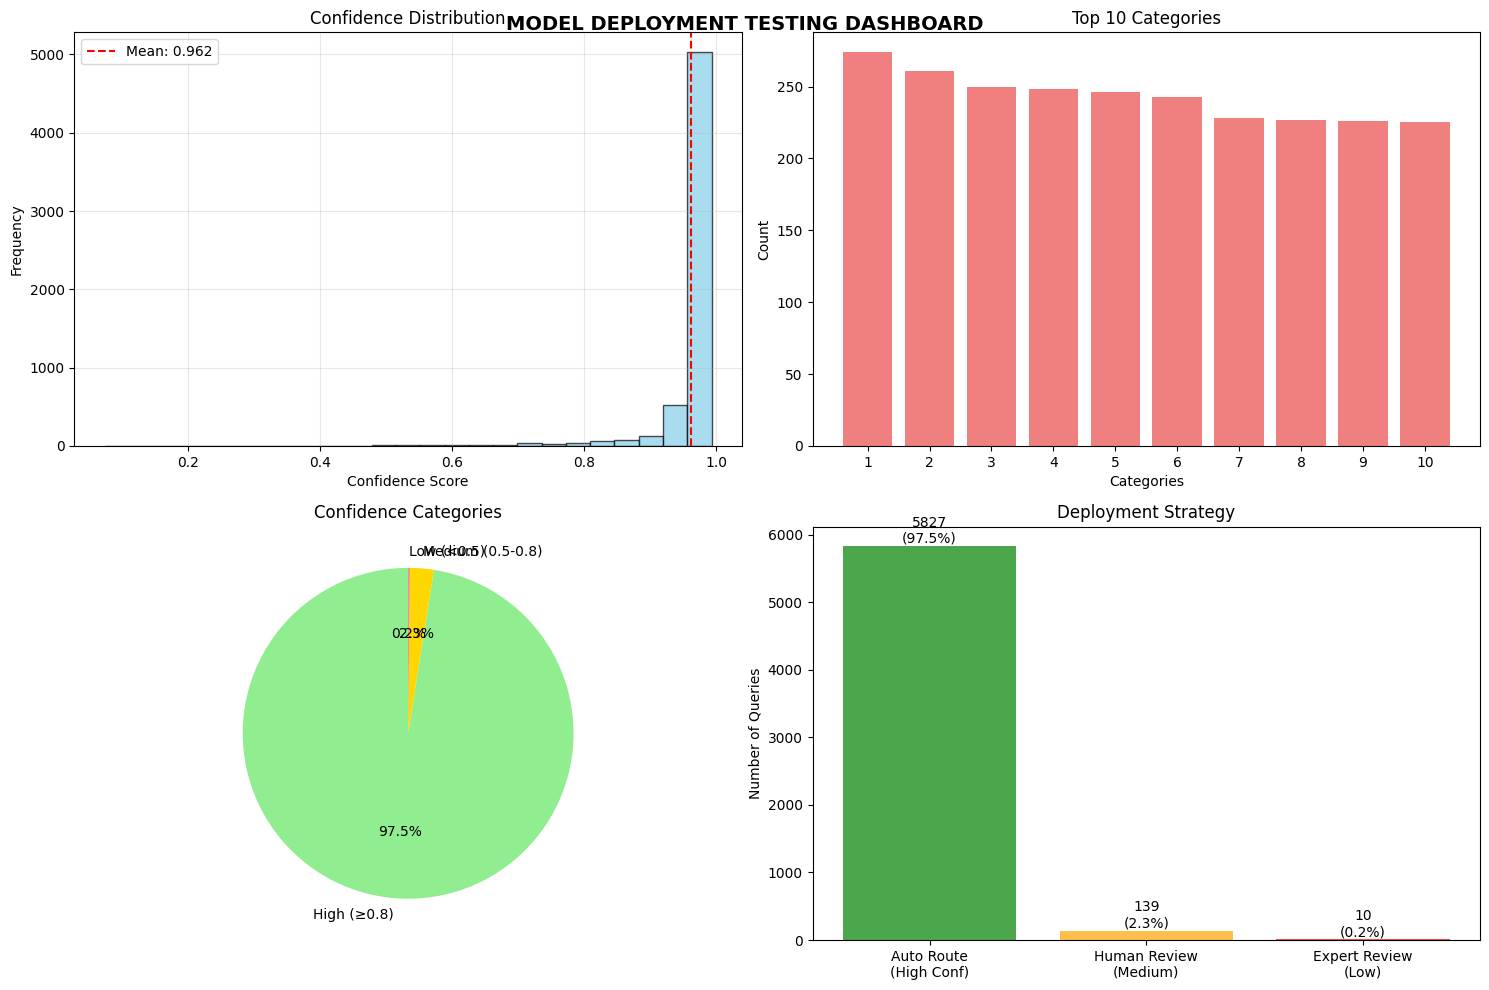


PREDICTION EXAMPLES
TOP 5 HIGH CONFIDENCE PREDICTIONS:

1. "use travel voucher book..."
   Predicted: Travel Vouchers
   Confidence: 0.993
   📊 Top alternatives:
      BEST Travel Vouchers: 0.993
       2. Flight Bookings: 0.002
       3. Travel Documentation: 0.001

2. "use travel voucher next book..."
   Predicted: Travel Vouchers
   Confidence: 0.993
   📊 Top alternatives:
      BEST Travel Vouchers: 0.993
       2. Flight Bookings: 0.002
       3. Travel Documentation: 0.001

3. "use travel voucher book..."
   Predicted: Travel Vouchers
   Confidence: 0.993
   📊 Top alternatives:
      BEST Travel Vouchers: 0.993
       2. Flight Bookings: 0.002
       3. Travel Documentation: 0.001

4. "use travel voucher book..."
   Predicted: Travel Vouchers
   Confidence: 0.993
   📊 Top alternatives:
      BEST Travel Vouchers: 0.993
       2. Flight Bookings: 0.002
       3. Travel Documentation: 0.001

5. "use travel voucher book..."
   Predicted: Travel Vouchers
   Confidence: 0.993
   📊 To

In [19]:
def main():
    """Execute deployment testing pipeline."""
    
    # 1. Load components
    model, vectorizer, label_encoder, model_name = load_components()
    if model is None:
        return
    
    # 2. Load test data
    test_data = load_test_data()
    
    # 3. Make predictions
    predictions = predict_with_confidence(
        model, vectorizer, label_encoder, test_data['query_lemmatized']
    )
    
    # 4. Analyze performance
    analytics = analyze_performance(predictions)
    
    # 5. Show examples
    show_examples(predictions)
    
    # 6. Deployment recommendations
    deployment_recommendations(analytics)
    
    print(f"\n TESTING COMPLETE!")
    print(f" Model: {model_name}")
    print(f" Samples Tested: {len(predictions):,}")
    print(f" Performance: {analytics['avg_confidence']:.3f} confidence")
    print(f" Results saved to: '../reports/figures/'")

# Execute pipeline
if __name__ == "__main__":
    main()